In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The Tens Of Thousands',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 'Fo

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

653

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328
 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 37

(522, 131, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

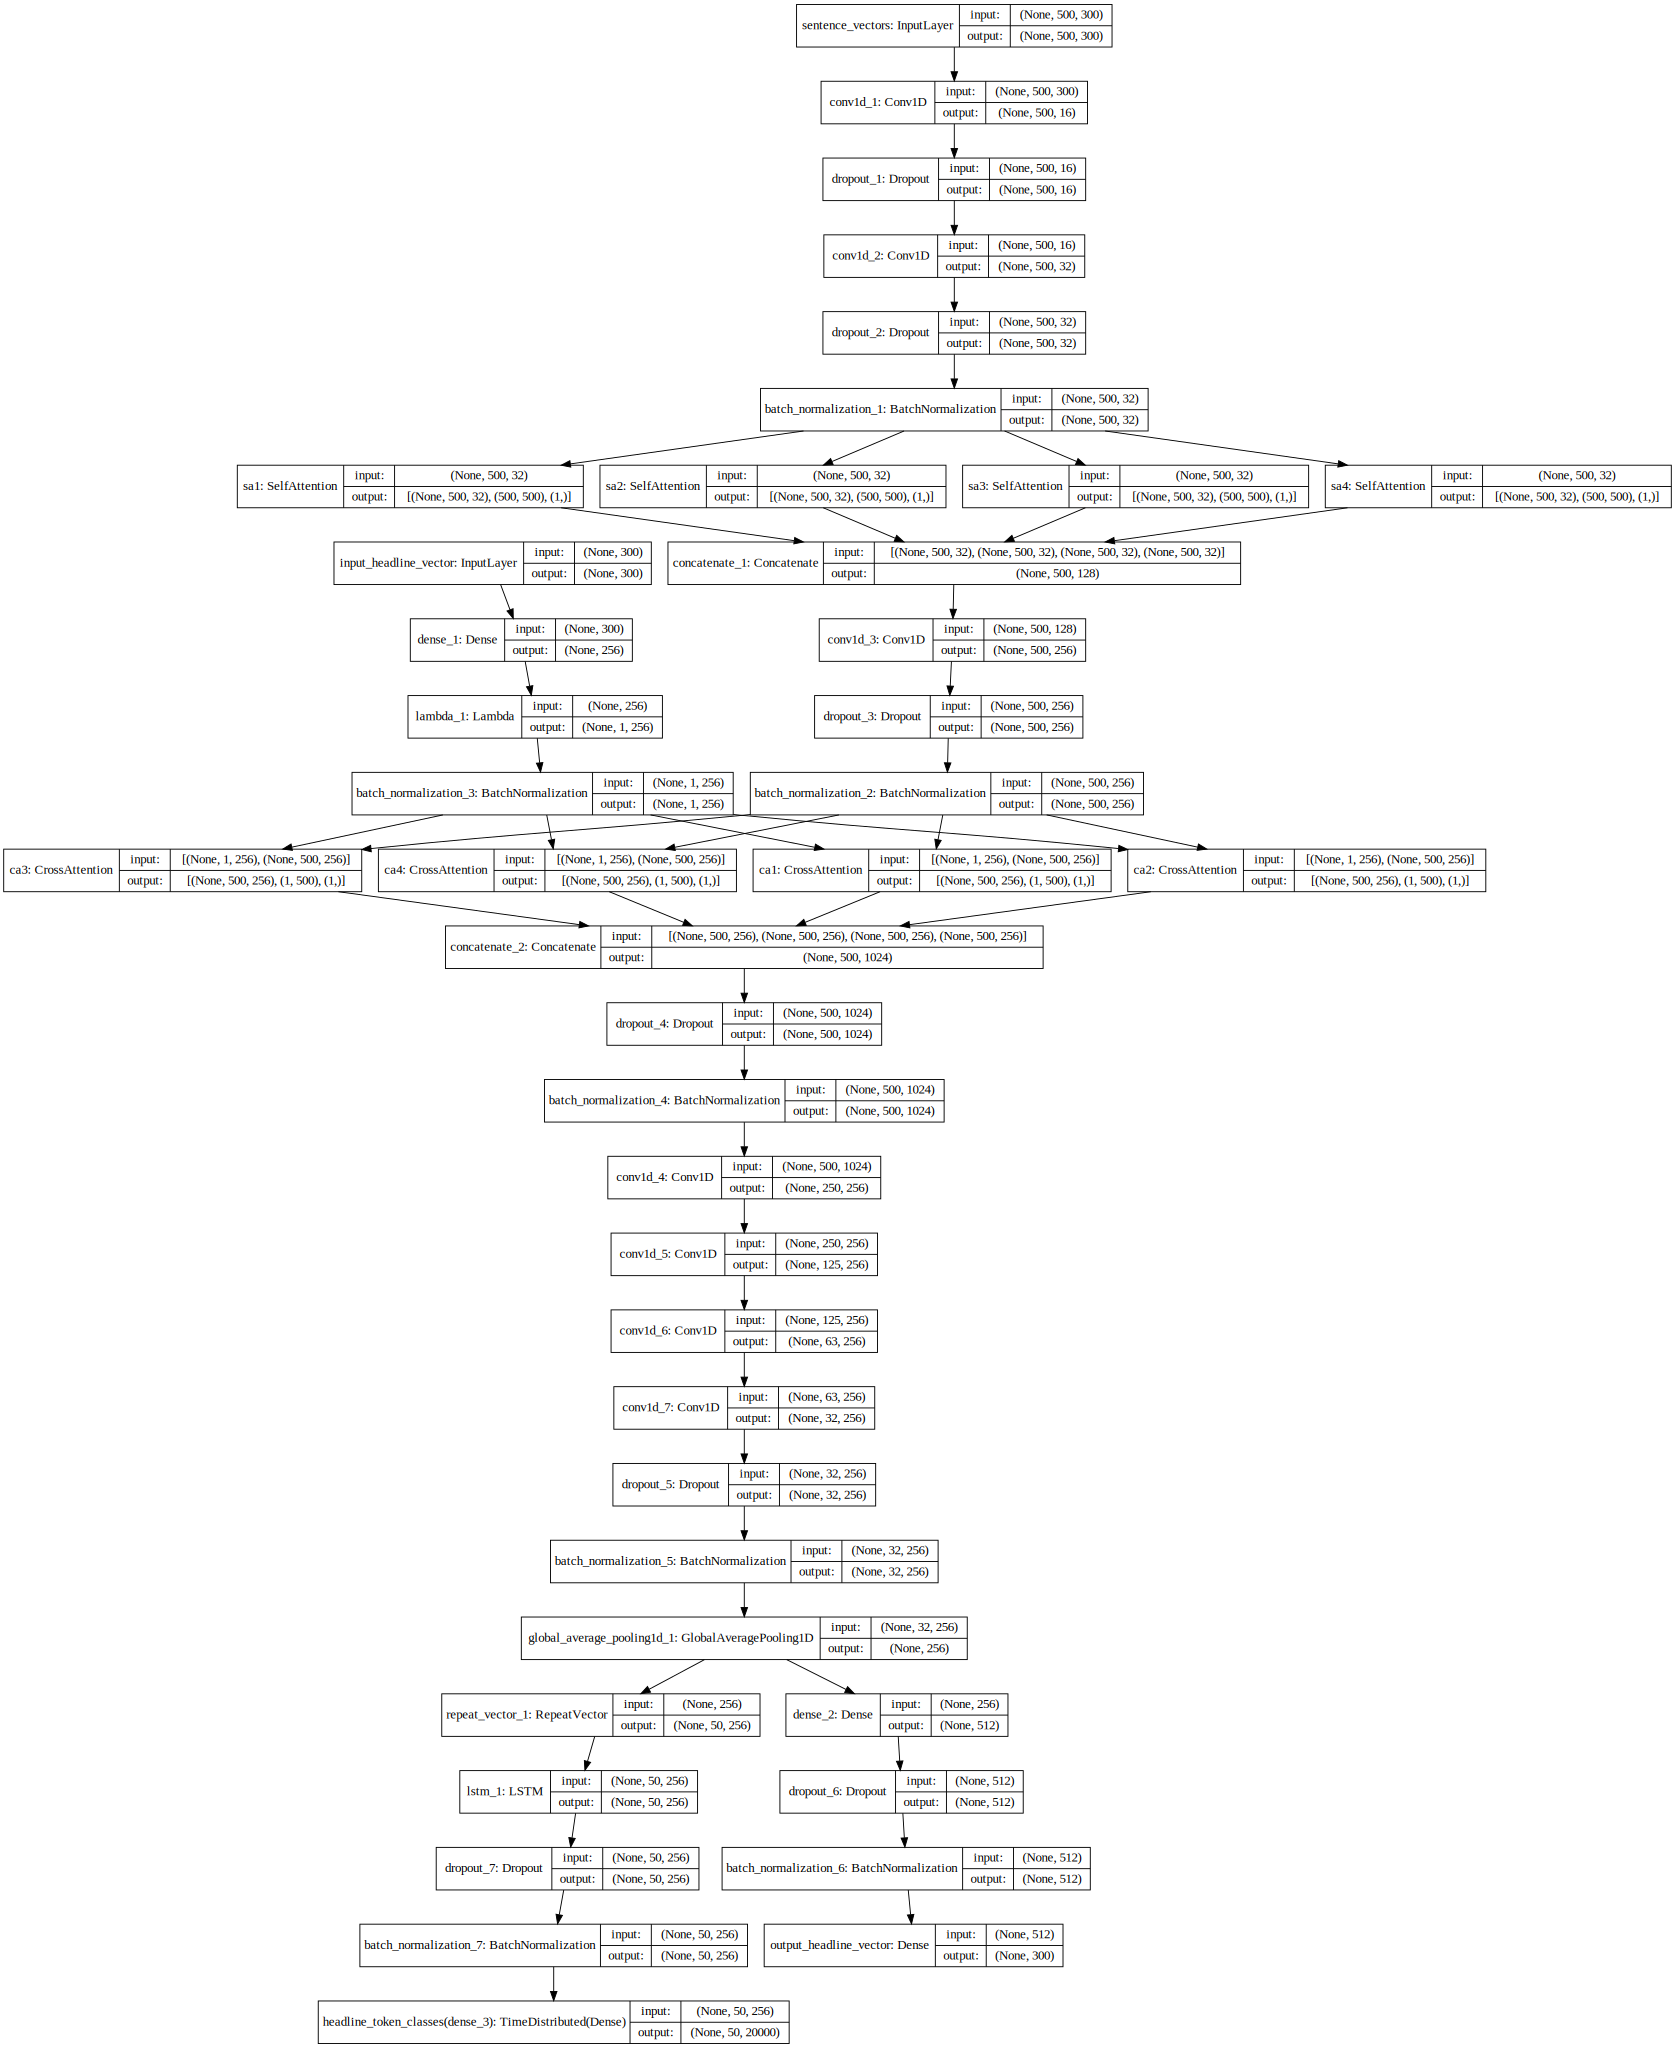

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_word = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],[gen_hd_vector,gen_hd_word])
    return model
model = build_model()
losses = {
    'output_headline_vector':'mse'
    ,'headline_token_classes':'categorical_crossentropy'
}
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss=losses)
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector_word_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector_word_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 51s 13s/step - loss: 11.0744 - output_headline_vector_loss: 1.1674 - headline_token_classes_loss: 9.9070 - val_loss: 10.3892 - val_output_headline_vector_loss: 0.4492 - val_headline_token_classes_loss: 9.9400
Epoch 2/2000
4/4 [==============================] - 2s 570ms/step - loss: 11.0579 - output_headline_vector_loss: 1.1545 - headline_token_classes_loss: 9.9034 - val_loss: 10.3178 - val_output_headline_vector_loss: 0.3825 - val_headline_token_classes_loss: 9.9352
Epoch 3/2000
4/4 [==============================] - 3s 698ms/step - loss: 11.0601 - output_headline_vector_loss: 1.1663 - headline_token_classes_loss: 9.8938 - val_loss: 10.2696 - val_output_headline_vector_loss: 0.3401 - val_headline_token_classes_loss: 9.9295
Epoch 4/2000
4/4 [==============================] - 2s 570ms/step - loss: 11.0296 - output_headline_vector_loss: 1.1417 - headline_token_classes_loss: 9.8879 - val_loss: 10.2082 - val_output_headline_vector_loss: 0.

Epoch 64/2000
4/4 [==============================] - 14s 4s/step - loss: 8.1073 - output_headline_vector_loss: 0.7389 - headline_token_classes_loss: 7.3685 - val_loss: 6.4103 - val_output_headline_vector_loss: 0.0955 - val_headline_token_classes_loss: 6.3148
Epoch 65/2000
4/4 [==============================] - 14s 3s/step - loss: 8.0888 - output_headline_vector_loss: 0.7211 - headline_token_classes_loss: 7.3678 - val_loss: 6.6000 - val_output_headline_vector_loss: 0.0895 - val_headline_token_classes_loss: 6.5105
Epoch 66/2000
4/4 [==============================] - 15s 4s/step - loss: 8.0220 - output_headline_vector_loss: 0.7177 - headline_token_classes_loss: 7.3043 - val_loss: 6.5876 - val_output_headline_vector_loss: 0.0812 - val_headline_token_classes_loss: 6.5064
Epoch 67/2000
4/4 [==============================] - 17s 4s/step - loss: 7.9385 - output_headline_vector_loss: 0.6972 - headline_token_classes_loss: 7.2414 - val_loss: 6.1845 - val_output_headline_vector_loss: 0.0804 - val_

Epoch 96/2000
4/4 [==============================] - 15s 4s/step - loss: 9.3036 - output_headline_vector_loss: 0.5997 - headline_token_classes_loss: 8.7039 - val_loss: 9.8050 - val_output_headline_vector_loss: 0.0574 - val_headline_token_classes_loss: 9.7476
Epoch 97/2000
4/4 [==============================] - 15s 4s/step - loss: 9.3048 - output_headline_vector_loss: 0.5908 - headline_token_classes_loss: 8.7141 - val_loss: 9.8903 - val_output_headline_vector_loss: 0.0594 - val_headline_token_classes_loss: 9.8309
Epoch 98/2000
4/4 [==============================] - 15s 4s/step - loss: 9.2664 - output_headline_vector_loss: 0.5894 - headline_token_classes_loss: 8.6770 - val_loss: 9.8715 - val_output_headline_vector_loss: 0.0564 - val_headline_token_classes_loss: 9.8151
Epoch 99/2000
4/4 [==============================] - 14s 4s/step - loss: 9.2196 - output_headline_vector_loss: 0.5922 - headline_token_classes_loss: 8.6274 - val_loss: 9.7412 - val_output_headline_vector_loss: 0.0614 - val_

4/4 [==============================] - 16s 4s/step - loss: 7.9926 - output_headline_vector_loss: 0.3971 - headline_token_classes_loss: 7.5955 - val_loss: 10.3730 - val_output_headline_vector_loss: 0.0335 - val_headline_token_classes_loss: 10.3395
Epoch 159/2000
4/4 [==============================] - 16s 4s/step - loss: 7.9409 - output_headline_vector_loss: 0.3851 - headline_token_classes_loss: 7.5558 - val_loss: 10.2889 - val_output_headline_vector_loss: 0.0398 - val_headline_token_classes_loss: 10.2491
Epoch 160/2000
4/4 [==============================] - 16s 4s/step - loss: 7.9281 - output_headline_vector_loss: 0.3888 - headline_token_classes_loss: 7.5394 - val_loss: 10.4851 - val_output_headline_vector_loss: 0.0344 - val_headline_token_classes_loss: 10.4507
Epoch 161/2000
4/4 [==============================] - 16s 4s/step - loss: 7.8982 - output_headline_vector_loss: 0.3809 - headline_token_classes_loss: 7.5172 - val_loss: 10.3864 - val_output_headline_vector_loss: 0.0322 - val_head

4/4 [==============================] - 15s 4s/step - loss: 6.5925 - output_headline_vector_loss: 0.2340 - headline_token_classes_loss: 6.3585 - val_loss: 9.3219 - val_output_headline_vector_loss: 0.0242 - val_headline_token_classes_loss: 9.2977
Epoch 221/2000
4/4 [==============================] - 15s 4s/step - loss: 6.6378 - output_headline_vector_loss: 0.2333 - headline_token_classes_loss: 6.4045 - val_loss: 9.4012 - val_output_headline_vector_loss: 0.0188 - val_headline_token_classes_loss: 9.3825
Epoch 222/2000
4/4 [==============================] - 15s 4s/step - loss: 6.6188 - output_headline_vector_loss: 0.2328 - headline_token_classes_loss: 6.3860 - val_loss: 9.1065 - val_output_headline_vector_loss: 0.0211 - val_headline_token_classes_loss: 9.0854
Epoch 223/2000
4/4 [==============================] - 15s 4s/step - loss: 6.5164 - output_headline_vector_loss: 0.2334 - headline_token_classes_loss: 6.2830 - val_loss: 9.3428 - val_output_headline_vector_loss: 0.0192 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 5.3044 - output_headline_vector_loss: 0.1356 - headline_token_classes_loss: 5.1688 - val_loss: 8.4303 - val_output_headline_vector_loss: 0.0153 - val_headline_token_classes_loss: 8.4150
Epoch 283/2000
4/4 [==============================] - 16s 4s/step - loss: 5.3569 - output_headline_vector_loss: 0.1319 - headline_token_classes_loss: 5.2250 - val_loss: 8.2283 - val_output_headline_vector_loss: 0.0189 - val_headline_token_classes_loss: 8.2093
Epoch 284/2000
4/4 [==============================] - 16s 4s/step - loss: 5.4128 - output_headline_vector_loss: 0.1275 - headline_token_classes_loss: 5.2854 - val_loss: 8.3888 - val_output_headline_vector_loss: 0.0153 - val_headline_token_classes_loss: 8.3735
Epoch 285/2000
4/4 [==============================] - 16s 4s/step - loss: 5.3259 - output_headline_vector_loss: 0.1343 - headline_token_classes_loss: 5.1916 - val_loss: 8.4655 - val_output_headline_vector_loss: 0.0148 - val_headline_to

4/4 [==============================] - 16s 4s/step - loss: 4.3506 - output_headline_vector_loss: 0.0815 - headline_token_classes_loss: 4.2691 - val_loss: 7.6011 - val_output_headline_vector_loss: 0.0130 - val_headline_token_classes_loss: 7.5880
Epoch 345/2000
4/4 [==============================] - 15s 4s/step - loss: 4.5467 - output_headline_vector_loss: 0.0730 - headline_token_classes_loss: 4.4737 - val_loss: 7.5993 - val_output_headline_vector_loss: 0.0124 - val_headline_token_classes_loss: 7.5869
Epoch 346/2000
4/4 [==============================] - 15s 4s/step - loss: 4.6383 - output_headline_vector_loss: 0.0772 - headline_token_classes_loss: 4.5611 - val_loss: 7.4002 - val_output_headline_vector_loss: 0.0136 - val_headline_token_classes_loss: 7.3866
Epoch 347/2000
4/4 [==============================] - 16s 4s/step - loss: 4.4971 - output_headline_vector_loss: 0.0759 - headline_token_classes_loss: 4.4211 - val_loss: 6.9798 - val_output_headline_vector_loss: 0.0222 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 3.7581 - output_headline_vector_loss: 0.0486 - headline_token_classes_loss: 3.7095 - val_loss: 6.8247 - val_output_headline_vector_loss: 0.0124 - val_headline_token_classes_loss: 6.8123
Epoch 407/2000
4/4 [==============================] - 15s 4s/step - loss: 3.9147 - output_headline_vector_loss: 0.0451 - headline_token_classes_loss: 3.8696 - val_loss: 6.8095 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 6.7989
Epoch 408/2000
4/4 [==============================] - 15s 4s/step - loss: 3.9046 - output_headline_vector_loss: 0.0433 - headline_token_classes_loss: 3.8612 - val_loss: 6.6408 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 6.6302
Epoch 409/2000
4/4 [==============================] - 15s 4s/step - loss: 3.6778 - output_headline_vector_loss: 0.0469 - headline_token_classes_loss: 3.6309 - val_loss: 6.4645 - val_output_headline_vector_loss: 0.0134 - val_headline_to

4/4 [==============================] - 16s 4s/step - loss: 3.3480 - output_headline_vector_loss: 0.0291 - headline_token_classes_loss: 3.3190 - val_loss: 5.5080 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 5.4974
Epoch 469/2000
4/4 [==============================] - 16s 4s/step - loss: 3.4352 - output_headline_vector_loss: 0.0299 - headline_token_classes_loss: 3.4052 - val_loss: 5.7140 - val_output_headline_vector_loss: 0.0115 - val_headline_token_classes_loss: 5.7025
Epoch 470/2000
4/4 [==============================] - 15s 4s/step - loss: 3.3691 - output_headline_vector_loss: 0.0298 - headline_token_classes_loss: 3.3393 - val_loss: 5.5640 - val_output_headline_vector_loss: 0.0114 - val_headline_token_classes_loss: 5.5525
Epoch 471/2000
4/4 [==============================] - 15s 4s/step - loss: 3.2795 - output_headline_vector_loss: 0.0279 - headline_token_classes_loss: 3.2515 - val_loss: 5.4091 - val_output_headline_vector_loss: 0.0108 - val_headline_to

4/4 [==============================] - 17s 4s/step - loss: 2.5315 - output_headline_vector_loss: 0.0203 - headline_token_classes_loss: 2.5112 - val_loss: 4.1787 - val_output_headline_vector_loss: 0.0124 - val_headline_token_classes_loss: 4.1663
Epoch 531/2000
4/4 [==============================] - 16s 4s/step - loss: 2.5806 - output_headline_vector_loss: 0.0202 - headline_token_classes_loss: 2.5604 - val_loss: 3.6467 - val_output_headline_vector_loss: 0.0090 - val_headline_token_classes_loss: 3.6377
Epoch 532/2000
4/4 [==============================] - 16s 4s/step - loss: 2.6175 - output_headline_vector_loss: 0.0182 - headline_token_classes_loss: 2.5993 - val_loss: 3.6541 - val_output_headline_vector_loss: 0.0099 - val_headline_token_classes_loss: 3.6443
Epoch 533/2000
4/4 [==============================] - 16s 4s/step - loss: 2.5246 - output_headline_vector_loss: 0.0180 - headline_token_classes_loss: 2.5065 - val_loss: 4.1417 - val_output_headline_vector_loss: 0.0115 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.4028 - output_headline_vector_loss: 0.0150 - headline_token_classes_loss: 2.3878 - val_loss: 3.7906 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 3.7793
Epoch 593/2000
4/4 [==============================] - 15s 4s/step - loss: 2.4886 - output_headline_vector_loss: 0.0142 - headline_token_classes_loss: 2.4745 - val_loss: 3.6909 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 3.6798
Epoch 594/2000
4/4 [==============================] - 14s 4s/step - loss: 2.4094 - output_headline_vector_loss: 0.0156 - headline_token_classes_loss: 2.3938 - val_loss: 3.7047 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 3.6946
Epoch 595/2000
4/4 [==============================] - 14s 3s/step - loss: 2.3764 - output_headline_vector_loss: 0.0152 - headline_token_classes_loss: 2.3612 - val_loss: 3.6679 - val_output_headline_vector_loss: 0.0101 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 2.2756 - output_headline_vector_loss: 0.0124 - headline_token_classes_loss: 2.2632 - val_loss: 3.4406 - val_output_headline_vector_loss: 0.0089 - val_headline_token_classes_loss: 3.4318
Epoch 655/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3571 - output_headline_vector_loss: 0.0129 - headline_token_classes_loss: 2.3442 - val_loss: 3.3744 - val_output_headline_vector_loss: 0.0119 - val_headline_token_classes_loss: 3.3626
Epoch 656/2000
4/4 [==============================] - 16s 4s/step - loss: 2.3898 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 2.3779 - val_loss: 3.2216 - val_output_headline_vector_loss: 0.0135 - val_headline_token_classes_loss: 3.2081
Epoch 657/2000
4/4 [==============================] - 16s 4s/step - loss: 2.3229 - output_headline_vector_loss: 0.0139 - headline_token_classes_loss: 2.3090 - val_loss: 3.2793 - val_output_headline_vector_loss: 0.0105 - val_headline_to

4/4 [==============================] - 14s 4s/step - loss: 2.1338 - output_headline_vector_loss: 0.0127 - headline_token_classes_loss: 2.1212 - val_loss: 2.9176 - val_output_headline_vector_loss: 0.0136 - val_headline_token_classes_loss: 2.9040
Epoch 717/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0255 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 2.0139 - val_loss: 3.0211 - val_output_headline_vector_loss: 0.0102 - val_headline_token_classes_loss: 3.0109
Epoch 718/2000
4/4 [==============================] - 16s 4s/step - loss: 2.1009 - output_headline_vector_loss: 0.0124 - headline_token_classes_loss: 2.0885 - val_loss: 3.1262 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 3.1162
Epoch 719/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1001 - output_headline_vector_loss: 0.0121 - headline_token_classes_loss: 2.0880 - val_loss: 2.9668 - val_output_headline_vector_loss: 0.0107 - val_headline_to

4/4 [==============================] - 16s 4s/step - loss: 1.9920 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 1.9807 - val_loss: 2.6387 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.6275
Epoch 779/2000
4/4 [==============================] - 16s 4s/step - loss: 2.0884 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 2.0774 - val_loss: 2.5772 - val_output_headline_vector_loss: 0.0129 - val_headline_token_classes_loss: 2.5643
Epoch 780/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0991 - output_headline_vector_loss: 0.0127 - headline_token_classes_loss: 2.0864 - val_loss: 2.5223 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.5115
Epoch 781/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9581 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 1.9471 - val_loss: 2.5558 - val_output_headline_vector_loss: 0.0113 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.8663 - output_headline_vector_loss: 0.0115 - headline_token_classes_loss: 1.8548 - val_loss: 2.3888 - val_output_headline_vector_loss: 0.0117 - val_headline_token_classes_loss: 2.3771
Epoch 841/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9892 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.9786 - val_loss: 2.4310 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.4188
Epoch 842/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9953 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.9848 - val_loss: 2.1842 - val_output_headline_vector_loss: 0.0141 - val_headline_token_classes_loss: 2.1702
Epoch 843/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9067 - output_headline_vector_loss: 0.0117 - headline_token_classes_loss: 1.8951 - val_loss: 2.3517 - val_output_headline_vector_loss: 0.0106 - val_headline_to

4/4 [==============================] - 16s 4s/step - loss: 1.8883 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.8775 - val_loss: 2.2037 - val_output_headline_vector_loss: 0.0172 - val_headline_token_classes_loss: 2.1865
Epoch 903/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8271 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 1.8157 - val_loss: 2.3304 - val_output_headline_vector_loss: 0.0112 - val_headline_token_classes_loss: 2.3192
Epoch 904/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7735 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 1.7616 - val_loss: 2.2317 - val_output_headline_vector_loss: 0.0112 - val_headline_token_classes_loss: 2.2206
Epoch 905/2000
4/4 [==============================] - 14s 3s/step - loss: 1.7905 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.7794 - val_loss: 2.4988 - val_output_headline_vector_loss: 0.0110 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.7804 - output_headline_vector_loss: 0.0117 - headline_token_classes_loss: 1.7688 - val_loss: 2.2716 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.2608
Epoch 965/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7413 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.7301 - val_loss: 2.1729 - val_output_headline_vector_loss: 0.0111 - val_headline_token_classes_loss: 2.1618
Epoch 966/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7554 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.7448 - val_loss: 2.3983 - val_output_headline_vector_loss: 0.0125 - val_headline_token_classes_loss: 2.3859
Epoch 967/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7371 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.7255 - val_loss: 2.2545 - val_output_headline_vector_loss: 0.0132 - val_headline_to

4/4 [==============================] - 15s 4s/step - loss: 1.7681 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.7575 - val_loss: 2.4576 - val_output_headline_vector_loss: 0.0101 - val_headline_token_classes_loss: 2.4476
Epoch 1027/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7283 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7178 - val_loss: 2.4120 - val_output_headline_vector_loss: 0.0132 - val_headline_token_classes_loss: 2.3988
Epoch 1028/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7745 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7636 - val_loss: 2.3386 - val_output_headline_vector_loss: 0.0109 - val_headline_token_classes_loss: 2.3277
Epoch 1029/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7425 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 1.7311 - val_loss: 2.5922 - val_output_headline_vector_loss: 0.0110 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7282 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.7167 - val_loss: 2.3239 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.3117
Epoch 1089/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7607 - output_headline_vector_loss: 0.0110 - headline_token_classes_loss: 1.7497 - val_loss: 2.4300 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 2.4200
Epoch 1090/2000
4/4 [==============================] - 14s 3s/step - loss: 1.8545 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.8438 - val_loss: 2.1956 - val_output_headline_vector_loss: 0.0106 - val_headline_token_classes_loss: 2.1850
Epoch 1091/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8583 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8480 - val_loss: 2.3201 - val_output_headline_vector_loss: 0.0109 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7727 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.7624 - val_loss: 2.0806 - val_output_headline_vector_loss: 0.0115 - val_headline_token_classes_loss: 2.0690
Epoch 1151/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7726 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7621 - val_loss: 2.4137 - val_output_headline_vector_loss: 0.0112 - val_headline_token_classes_loss: 2.4025
Epoch 1152/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8521 - output_headline_vector_loss: 0.0100 - headline_token_classes_loss: 1.8420 - val_loss: 2.3130 - val_output_headline_vector_loss: 0.0118 - val_headline_token_classes_loss: 2.3012
Epoch 1153/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8071 - output_headline_vector_loss: 0.0117 - headline_token_classes_loss: 1.7954 - val_loss: 2.2408 - val_output_headline_vector_loss: 0.0109 - val_headline

4/4 [==============================] - 14s 4s/step - loss: 1.6958 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.6850 - val_loss: 2.2192 - val_output_headline_vector_loss: 0.0132 - val_headline_token_classes_loss: 2.2061
Epoch 1213/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8101 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.7995 - val_loss: 2.1682 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.1575
Epoch 1214/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7679 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.7572 - val_loss: 2.1678 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.1570
Epoch 1215/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6528 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.6422 - val_loss: 2.4678 - val_output_headline_vector_loss: 0.0115 - val_headline

4/4 [==============================] - 14s 4s/step - loss: 1.7872 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.7770 - val_loss: 2.1842 - val_output_headline_vector_loss: 0.0188 - val_headline_token_classes_loss: 2.1654
Epoch 1275/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8622 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.8513 - val_loss: 2.5389 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.5282
Epoch 1276/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6159 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.6054 - val_loss: 2.2309 - val_output_headline_vector_loss: 0.0130 - val_headline_token_classes_loss: 2.2179
Epoch 1277/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7339 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.7236 - val_loss: 2.2231 - val_output_headline_vector_loss: 0.0109 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.6769 - output_headline_vector_loss: 0.0118 - headline_token_classes_loss: 1.6651 - val_loss: 2.1016 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.0910
Epoch 1337/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7266 - output_headline_vector_loss: 0.0117 - headline_token_classes_loss: 1.7149 - val_loss: 2.6373 - val_output_headline_vector_loss: 0.0092 - val_headline_token_classes_loss: 2.6281
Epoch 1338/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6363 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.6247 - val_loss: 2.2553 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.2440
Epoch 1339/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7626 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.7510 - val_loss: 1.8722 - val_output_headline_vector_loss: 0.0110 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.9022 - output_headline_vector_loss: 0.0113 - headline_token_classes_loss: 1.8909 - val_loss: 2.5007 - val_output_headline_vector_loss: 0.0098 - val_headline_token_classes_loss: 2.4909
Epoch 1399/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9629 - output_headline_vector_loss: 0.0118 - headline_token_classes_loss: 1.9511 - val_loss: 2.2575 - val_output_headline_vector_loss: 0.0096 - val_headline_token_classes_loss: 2.2479
Epoch 1400/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9449 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.9343 - val_loss: 2.2259 - val_output_headline_vector_loss: 0.0123 - val_headline_token_classes_loss: 2.2136
Epoch 1401/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0426 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 2.0321 - val_loss: 2.3677 - val_output_headline_vector_loss: 0.0098 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.8891 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.8780 - val_loss: 2.0710 - val_output_headline_vector_loss: 0.0149 - val_headline_token_classes_loss: 2.0561
Epoch 1461/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8579 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8477 - val_loss: 2.4443 - val_output_headline_vector_loss: 0.0101 - val_headline_token_classes_loss: 2.4342
Epoch 1462/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8170 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.8065 - val_loss: 2.4367 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.4254
Epoch 1463/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8007 - output_headline_vector_loss: 0.0123 - headline_token_classes_loss: 1.7884 - val_loss: 2.0899 - val_output_headline_vector_loss: 0.0101 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.7892 - output_headline_vector_loss: 0.0114 - headline_token_classes_loss: 1.7778 - val_loss: 1.7648 - val_output_headline_vector_loss: 0.0119 - val_headline_token_classes_loss: 1.7530
Epoch 1523/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7604 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.7494 - val_loss: 2.4995 - val_output_headline_vector_loss: 0.0083 - val_headline_token_classes_loss: 2.4912
Epoch 1524/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8765 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.8662 - val_loss: 2.2896 - val_output_headline_vector_loss: 0.0149 - val_headline_token_classes_loss: 2.2747
Epoch 1525/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7589 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7484 - val_loss: 2.4654 - val_output_headline_vector_loss: 0.0116 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.7886 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.7779 - val_loss: 2.4452 - val_output_headline_vector_loss: 0.0113 - val_headline_token_classes_loss: 2.4338
Epoch 1585/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6629 - output_headline_vector_loss: 0.0116 - headline_token_classes_loss: 1.6513 - val_loss: 2.3308 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 2.3208
Epoch 1586/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8404 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.8295 - val_loss: 2.2293 - val_output_headline_vector_loss: 0.0160 - val_headline_token_classes_loss: 2.2133
Epoch 1587/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7333 - output_headline_vector_loss: 0.0103 - headline_token_classes_loss: 1.7229 - val_loss: 2.2434 - val_output_headline_vector_loss: 0.0109 - val_headline

4/4 [==============================] - 15s 4s/step - loss: 1.6723 - output_headline_vector_loss: 0.0107 - headline_token_classes_loss: 1.6616 - val_loss: 2.2316 - val_output_headline_vector_loss: 0.0100 - val_headline_token_classes_loss: 2.2216
Epoch 1647/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6524 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.6415 - val_loss: 2.2742 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.2635
Epoch 1648/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6882 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.6770 - val_loss: 1.9932 - val_output_headline_vector_loss: 0.0109 - val_headline_token_classes_loss: 1.9823
Epoch 1649/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7197 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7089 - val_loss: 2.3918 - val_output_headline_vector_loss: 0.0112 - val_headline

4/4 [==============================] - 16s 4s/step - loss: 1.6344 - output_headline_vector_loss: 0.0111 - headline_token_classes_loss: 1.6233 - val_loss: 2.7270 - val_output_headline_vector_loss: 0.0096 - val_headline_token_classes_loss: 2.7174
Epoch 1709/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5629 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.5521 - val_loss: 2.1507 - val_output_headline_vector_loss: 0.0132 - val_headline_token_classes_loss: 2.1375
Epoch 1710/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6068 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.5963 - val_loss: 2.1512 - val_output_headline_vector_loss: 0.0107 - val_headline_token_classes_loss: 2.1405
Epoch 1711/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7321 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7216 - val_loss: 2.3457 - val_output_headline_vector_loss: 0.0105 - val_headline

4/4 [==============================] - 12s 3s/step - loss: 1.7903 - output_headline_vector_loss: 0.0109 - headline_token_classes_loss: 1.7794 - val_loss: 2.1954 - val_output_headline_vector_loss: 0.0108 - val_headline_token_classes_loss: 2.1846
Epoch 1771/2000
4/4 [==============================] - 13s 3s/step - loss: 1.6052 - output_headline_vector_loss: 0.0112 - headline_token_classes_loss: 1.5940 - val_loss: 2.1278 - val_output_headline_vector_loss: 0.0126 - val_headline_token_classes_loss: 2.1152
Epoch 1772/2000
4/4 [==============================] - 12s 3s/step - loss: 1.7305 - output_headline_vector_loss: 0.0105 - headline_token_classes_loss: 1.7200 - val_loss: 2.0953 - val_output_headline_vector_loss: 0.0162 - val_headline_token_classes_loss: 2.0790
Epoch 1773/2000
4/4 [==============================] - 13s 3s/step - loss: 1.7127 - output_headline_vector_loss: 0.0118 - headline_token_classes_loss: 1.7009 - val_loss: 1.9915 - val_output_headline_vector_loss: 0.0130 - val_headline

4/4 [==============================] - 12s 3s/step - loss: 1.6139 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.6033 - val_loss: 2.5014 - val_output_headline_vector_loss: 0.0101 - val_headline_token_classes_loss: 2.4914
Epoch 1833/2000
4/4 [==============================] - 12s 3s/step - loss: 1.8128 - output_headline_vector_loss: 0.0117 - headline_token_classes_loss: 1.8011 - val_loss: 2.4496 - val_output_headline_vector_loss: 0.0110 - val_headline_token_classes_loss: 2.4385
Epoch 1834/2000
4/4 [==============================] - 11s 3s/step - loss: 1.6632 - output_headline_vector_loss: 0.0108 - headline_token_classes_loss: 1.6524 - val_loss: 2.2082 - val_output_headline_vector_loss: 0.0134 - val_headline_token_classes_loss: 2.1948
Epoch 1835/2000
4/4 [==============================] - 13s 3s/step - loss: 1.6988 - output_headline_vector_loss: 0.0101 - headline_token_classes_loss: 1.6888 - val_loss: 2.0943 - val_output_headline_vector_loss: 0.0140 - val_headline

4/4 [==============================] - 11s 3s/step - loss: 1.6243 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.6136 - val_loss: 2.3821 - val_output_headline_vector_loss: 0.0118 - val_headline_token_classes_loss: 2.3703
Epoch 1895/2000
4/4 [==============================] - 10s 3s/step - loss: 1.7177 - output_headline_vector_loss: 0.0099 - headline_token_classes_loss: 1.7078 - val_loss: 2.1412 - val_output_headline_vector_loss: 0.0110 - val_headline_token_classes_loss: 2.1302
Epoch 1896/2000
4/4 [==============================] - 11s 3s/step - loss: 1.6075 - output_headline_vector_loss: 0.0106 - headline_token_classes_loss: 1.5970 - val_loss: 2.1480 - val_output_headline_vector_loss: 0.0122 - val_headline_token_classes_loss: 2.1358
Epoch 1897/2000
4/4 [==============================] - 11s 3s/step - loss: 1.6466 - output_headline_vector_loss: 0.0099 - headline_token_classes_loss: 1.6368 - val_loss: 1.9193 - val_output_headline_vector_loss: 0.0148 - val_headline

4/4 [==============================] - 6s 1s/step - loss: 1.6787 - output_headline_vector_loss: 0.0100 - headline_token_classes_loss: 1.6687 - val_loss: 2.3267 - val_output_headline_vector_loss: 0.0120 - val_headline_token_classes_loss: 2.3147
Epoch 1957/2000
4/4 [==============================] - 5s 1s/step - loss: 1.6043 - output_headline_vector_loss: 0.0119 - headline_token_classes_loss: 1.5924 - val_loss: 2.2702 - val_output_headline_vector_loss: 0.0103 - val_headline_token_classes_loss: 2.2598
Epoch 1958/2000
4/4 [==============================] - 5s 1s/step - loss: 1.7482 - output_headline_vector_loss: 0.0097 - headline_token_classes_loss: 1.7385 - val_loss: 2.2281 - val_output_headline_vector_loss: 0.0115 - val_headline_token_classes_loss: 2.2166
Epoch 1959/2000
4/4 [==============================] - 6s 1s/step - loss: 1.6474 - output_headline_vector_loss: 0.0099 - headline_token_classes_loss: 1.6375 - val_loss: 2.3810 - val_output_headline_vector_loss: 0.0099 - val_headline_tok

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_vector_word_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., steps=5, use_multiprocessing=True)`
  


[2.2396193504333497, 0.011775833927094937, 2.2278435707092283]

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['us officials try to scare voters with terror threat',
       'obama declares his family will move to canada if trump is elected',
       'hillary clinton used hand signals to rig debate?',
       'hillary’s (islamic) america is already here where ‘muslim no-go zones’ are popping up all over michiganistan',
       'former nato chief: we need us as ‘world’s policeman’',
       'trump accuses obama, hillary clinton of founding daesh',
       'top aide: hillary ‘still not perfect in her head’, wikileaks',
       "fantastic! trump's 7 point plan to reform healthcare begins with a bombshell! » 100percentfedup.com",
       'us officials try to scare voters with terror threat',
       '(video) female college students protesting because ‘trump is a rapist’',
       'hillary friend bribed fbi agent and his wife',
       'fbi director received millions from clinton foundation, his brother’s law firm does clinton’s taxes',
       "physician confirms hillary clinton has parkinson's disease"

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'hillary clinton used hand signals to rig debate?'

In [27]:
x['sentences'][test_idx]

['Hillary Clinton is not above cheating, lying or stealing to get what she wants.',
 'So it shouldn’t be any surprise that she is being accused of cheating during Monday’s 1st Presidential debate.',
 'Clinton was accused of cheating by sending hand signals to the moderator Lester Holt.',
 'During the debate when Clinton wanted to signal Holt whent she wanted the floor, she rubbed her face in a manner similar to a baseball manager.',
 'According to True Pundit she has not done this in any other debates during her career supporting the accusation that these were signals.',
 'Author and journalist Mike Cernovich reached out to poker pros to see if Hillary was signalling Lester Holt with hand gestures during Monday’s debate.']

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([4, 3, 5, 2, 1])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

6


146.41356

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'hillary clinton used hand signals to rig debate?'

['So it shouldn’t be any surprise that she is being accused of cheating during Monday’s 1st Presidential debate.',
 'Clinton was accused of cheating by sending hand signals to the moderator Lester Holt.',
 'During the debate when Clinton wanted to signal Holt whent she wanted the floor, she rubbed her face in a manner similar to a baseball manager.']

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

4 : According to True Pundit she has not done this in any other debates during her career supporting the accusation that these were signals.
3 : During the debate when Clinton wanted to signal Holt whent she wanted the floor, she rubbed her face in a manner similar to a baseball manager.
5 : Author and journalist Mike Cernovich reached out to poker pros to see if Hillary was signalling Lester Holt with hand gestures during Monday’s debate.
2 : Clinton was accused of cheating by sending hand signals to the moderator Lester Holt.
1 : So it shouldn’t be any surprise that she is being accused of cheating during Monday’s 1st Presidential debate.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

6


146.41356

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

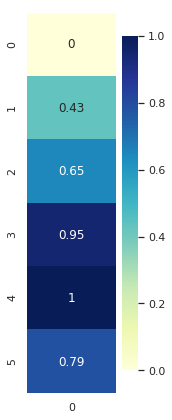

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(6, 6)

In [47]:
df_sb = pd.DataFrame(sb)


zx = df_sb.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
zx_scaled = min_max_scaler.fit_transform(zx)
df_sb = pd.DataFrame(zx_scaled)

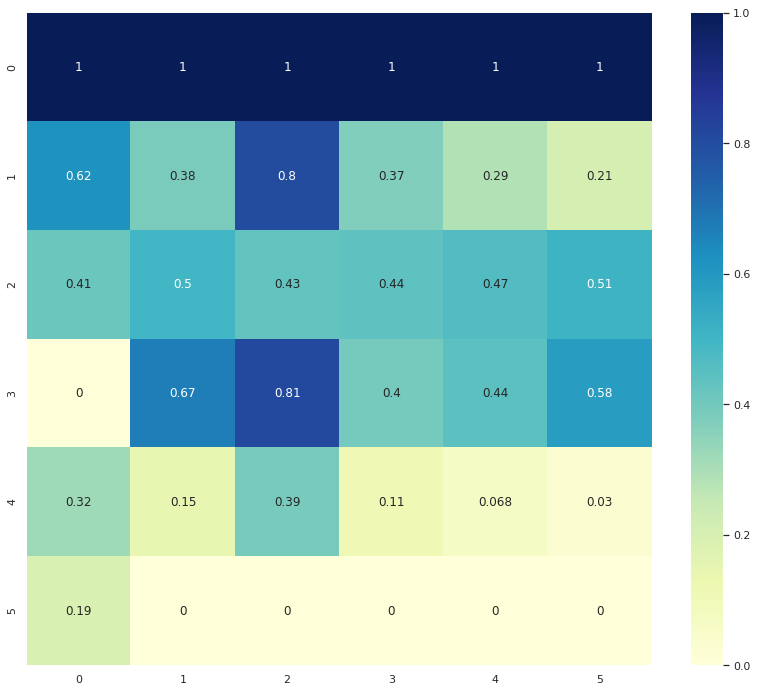

In [48]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [43]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"Hillary Clinton is not above cheating, lying or stealing to get what she wants."
1,So it shouldn’t be any surprise that she is being accused of cheating during Monday’s 1st Presidential debate.
2,Clinton was accused of cheating by sending hand signals to the moderator Lester Holt.
3,"During the debate when Clinton wanted to signal Holt whent she wanted the floor, she rubbed her face in a manner similar to a baseball manager."
4,According to True Pundit she has not done this in any other debates during her career supporting the accusation that these were signals.
5,Author and journalist Mike Cernovich reached out to poker pros to see if Hillary was signalling Lester Holt with hand gestures during Monday’s debate.


In [44]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles300[ar_id]
        vectors = article_vectors300[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [45]:

# display(testX['headline'])

# Evaluation for P, R, F1

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.37300000000000005, 0.5006666666666667, 0.4275055322396032)

In [49]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
#     print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.2808510638297872, 0.11621676196144283, 0.16440315287033902)